In [20]:
import pandas as pd
import numpy as np

from calc_fx import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# DATA_DIR = config("DATA_DIR")

DATA_DIR = r"../../../FS-project_files/FX-files"

# Initial Pull and analysis

FX_MONTHLY = r"fx_monthly_data.parquet"
FX_DAILY = r"fx_daily_data.parquet"
FX_FORWARD = r"fx_forward_points.parquet"
FX_SPOT_RATES = r"fx_spot_rates.parquet"
FX_INTEREST_RATES = r"fx_interest_rates.parquet"

In [22]:
fx_month = pd.read_parquet(f"{DATA_DIR}/{FX_MONTHLY}")
fx_day = pd.read_parquet(f"{DATA_DIR}/{FX_DAILY}")
fx_forward = pd.read_parquet(f"{DATA_DIR}/{FX_FORWARD}")
fx_spot = pd.read_parquet(f"{DATA_DIR}/{FX_SPOT_RATES}")
fx_interest = pd.read_parquet(f"{DATA_DIR}/{FX_INTEREST_RATES}")

In [25]:
fx_data = prepare_fx_data(fx_spot, fx_forward, fx_interest)

In [29]:
ret_list = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NZD', 'SEK', 'USD']

In [ ]:
def implied_fx_returns(fx_data, ret_list, bus_day_window=60):
    # use 3 month returns as a default (12 weeks or so)
    # _spot is spot rate
    # _ir is interest rate

    # annualize returns at the end
    # using average interest rate
    fx_df = fx_data.copy()
    fx_df = fx_df.fillna(method='ffill')
    ret_cols = ['USD_annual_ret']
    for curr_name in ret_list:
        int_col = f"{curr_name}_ir"

        fx_df[f"{int_col}_log"] = np.log(fx_df[int_col] / 100 + 1)
        
        #annualize
        fx_df[f"{int_col}_log_tot"] = fx_df[f"{int_col}_log"].rolling(window=bus_day_window).sum() / 365.25
        
        if curr_name == "USD":
            fx_df["USD_annual_ret"] = fx_df[f"{int_col}_log_tot"] * 365.25 * 100 / bus_day_window

            continue    
        
        spot_col = f"{curr_name}_spot"
        fx_df[f"{spot_col}_log_diff"] = np.log(fx_df[spot_col] / fx_df[spot_col].shift(bus_day_window))
        annual_ret_col = f"{curr_name}_annual_ret"
        fx_df[annual_ret_col] = (fx_df[f"{spot_col}_log_diff"] + fx_df[f"{int_col}_log_tot"]) * 365.25 * 100 / bus_day_window
        ret_cols.append(annual_ret_col)

    return fx_df[ret_cols]
        

        


In [70]:
impl_fx_ret = implied_fx_returns(fx_data, ret_list)

C:\Users\xuv14\AppData\Local\Temp\ipykernel_6964\117797396.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fx_df = fx_df.fillna(method='ffill')


<Axes: xlabel='index'>

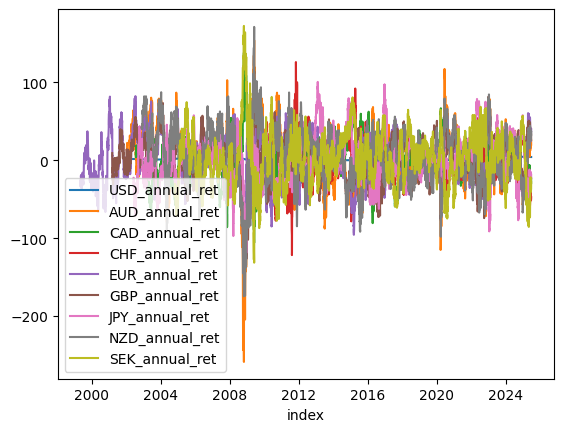

In [73]:
impl_fx_ret.plot()